# <center> News Classification with NLP and Neural Networks</center>

### Imports

In [2]:
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from sklearn import preprocessing
import plotly.graph_objects as go
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import string
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
warnings.filterwarnings('ignore')

### Data
- Import JSON file
- Inspect

In [3]:
# Read in json file to DataFrame
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

# View Results
print(df.shape)
df.sample(5)

(200853, 6)


,category,headline,authors,link,short_description,date
73681,BLACK VOICES,Misty Copeland Is Helping To Bring Dance Lesso...,Rahel Gebreyes,https://www.huffingtonpost.com/entry/misty-cop...,"The dancer just returned from Kigali, Rwanda, ...",2015-11-26
184183,WELLNESS,A Life Well-Spent,"Frank A. Weil, Contributor\nContributor",https://www.huffingtonpost.com/entry/life-well...,The more people ultimately know about their op...,2012-07-25
62173,POLITICS,House Republicans Say Oil Spill Prevention Rul...,,https://www.huffingtonpost.comhttp://thinkprog...,Almost five years after the 2010 Deepwater Hor...,2016-04-05
131697,PARENTING,Who Will Define Our Children?,"Rosemary Strembicki, Contributor\nParenting Co...",https://www.huffingtonpost.com/entry/who-will-...,"Do we want them to be like us, or totally diff...",2014-02-04
165687,WELLNESS,Five Tips to Maintain Lifelong Friends,"Lisa Firestone, Contributor\nPsychology expert...",https://www.huffingtonpost.com/entry/friendshi...,Holding yourself to these five standards will ...,2013-02-09


# Cleaning

#### Handle Duplicates

In [4]:
print(f"There are {df.duplicated().sum()} duplicated rows")

# Drop duplicates
df = df.drop_duplicates()

print(f"After dropping, there are now {df.duplicated().sum()} duplicated rows")

There are 13 duplicated rows
After dropping, there are now 0 duplicated rows


### Dates
- Cast Dates to years, unlikely day/month will be meaningful

In [5]:
df['date'] = df['date'].dt.year

#### Authors 
- The `authors` field is a list containing:
    - Name(s)
    - Titles
    - Organizations
    - Misc comments
- It also contains many NaNs in the form of empty strings
- Approach:
    - Replace NaNs with 'unknown'
    - Extract author names from the field, create new field named `author_names` to be used as a bigram

### Author Names
- Replace missing with NaN
- Remove unnecessary characters
- Fix common formatting issues
- Stripe whitespace

In [6]:
# Replace missing authors with 'unknown'
df['authors'] = df['authors'].apply(lambda x: x.replace('','unknown') if x == '' else x.replace('By','').replace('\n','').replace('Contributor','Contributor ').strip())

### Links
- The links are not helpful in their current form, need to extract keyworks from them

In [7]:
# Replace charaters we want to split on with commas, then split, only get the relevant entries from the resulting list
df['link_keywords'] = df['link'].apply(lambda x: x.replace('-',',').replace("_",',').replace("entry/",',').split(',')[1:-2])

# Typecast from list to string
df['link_keywords'] = df['link_keywords'].apply(lambda x: ' '.join(x))

### Join all text columns

In [8]:
df['text'] = df['headline'] + ' ' + df['short_description'] + ' ' + df['link_keywords'] + ' ' + df['authors'] + ' ' + df['date'].astype(str)

### Drop unwanted features

In [9]:
# Drop the feature if it appear in the colums (done this way so the cell can be re-run)
df = df.drop(columns=[col for col in df.columns if col in ['link','authors','headline','short_description','date','link_keywords','author_notes']])

# View Sample
df.sample(5)

,category,text
156357,BUSINESS,Restaurants Fear Sales Hit From Proposed Stric...
53956,CRIME,Former NYPD Detective Gets Emotional Over Dall...
91670,SPORTS,"The Ring's the Thing Back in 1977, I was in th..."
61289,POLITICS,Trey Gowdy Injects Benghazi Into The 2016 camp...
4033,BLACK VOICES,Chloe x Halle On The Importance Of Showing Bla...


# <center> -------------------------------------------------------------------- </center>

# EDA

#### View categories

#### View length of texts

#### Author Activity

#### Word Frequency Dictionary - All Categories
- Loop through each text, count the number of times the word appears

In [10]:
# Get count of all unique words
word_dict = {}

for text in df['text']:
    for word in text.split():
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1
            
word_dict_sorted = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse= True))

#### Plot the number of appearances for top words

### Takeaway:
- None of these appear to be meaningful words, and will most likely not be helpful in classifying the texts
- Next, lets look at the word counts broken out by category, instead of across all of them

#### Word Frequency Dictionary - By Category
- Loop through each text, count the number of times the word appears within each category

#### View top words from the 1st 5 categories

### Takeaway:
- None of these appear to be meaningful words either
- Need to recreate these views after removing stop words

# <center> -------------------------------------------------------------------- </center>

# Preprocessing Text Data
- Need to represent our texts in a way models can understand
    - Vectorize text (strings --> tokens --> vectors)
- Preprocessing Decisions:
    - How to vectorize:
        - Count vectorizaiton (binary / counts)
        - Term Frequency / Inverse Document Frequency
    - Stop words:
        - Do we remove them, if so which ones?      
    - Stemming / Lemmatization
    - n-grams
- Modelling:
    - Naive Bayes 
    - Neural Network

In [11]:
# Get a list of all words that only appear once throughout all texts
single_count_words = [word for word,count in word_dict.items() if count < 2]

### Get Stopwords

In [12]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ["''", '""', '...', '``'] 

### Encode Target Variable
- Assign a unique value to each categories

In [13]:
# Instantiate label encoder 
le = preprocessing.LabelEncoder()

# Label Encode categories
df['class_label'] = le.fit_transform(df['category'])

# Create dictionary to map labels to categories
label_to_category = dict(df.groupby('class_label')['category'].first())

### Create Stemmer and Lemmatizer

In [14]:
ps = PorterStemmer()
lm = WordNetLemmatizer()

def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    return [ps.stem(word) for word in tokens]

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    return [lm.lemmatize(word) for word in tokens]

In [15]:
# Define dependent and independent variables
X = df["text"]
y = df["class_label"]

# Test Train Validation Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=8)

### Define function to tokenize text given several arguments
- Create function to perform all variants of vectorizing we want to do

In [16]:
def tokenize_and_vectorize(X, X_train, X_test, X_val, sw, tf_idf = False, binary_count = False, ngrams = 1, stem = False, lemmatize = False, max_df = 1.0, min_df = 1, max_features = None):
    
    tk = None
    
    if stem == True:
        tk = tokenize_and_stem
    if lemmatize == True:
        tk = tokenize_and_lemmatize
        
    if tf_idf == False:
        vect = CountVectorizer
    else:
        vect = TfidfVectorizer
                
    vectorizer = vect( stop_words= sw,
                       tokenizer = tk,
                       binary = binary_count,
                       strip_accents = 'unicode',
                       ngram_range= (1,ngrams),
                       max_df = max_df,
                       min_df = min_df)

    # Fit the tokenizer on the training data
    vectorizer.fit(X_train)

    # Apply the tokenizer to the training and testing data
    X_counts = vectorizer.transform(X)
    X_train_counts = vectorizer.transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
    X_val_counts = vectorizer.transform(X_val)
    
    return X_counts, X_train_counts, X_test_counts, X_val_counts, vectorizer

In [18]:
# Tokenize and Vectorize
X_counts, X_train_counts, X_test_counts, X_val_counts, count_cv = tokenize_and_vectorize(X, X_train, X_test, X_val, sw = stopwords_list)

#### Cast to DataFrame and Inspect

#### Word Frequency Dictionary - All Categories
- Loop through each text, count the number of times the word appears

#### Plot the number of appearances for top words

#### Word Frequency Dictionary - By Category
- Loop through each text, count the number of times the word appears within each category

#### View top words from the 1st 5 categories

# <center> -------------------------------------------------------------------- </center>

# <center> Modelling </center>

## Multinomial Naive Bayes
- Build models for
    - Simple counts
    - Bigrams
    - Stemmed
    - Lemmatized
    - Extra Stop Words

In [17]:
# Define function to evaluate the model

def nb_evaluation(actuals, predictions):
    ''' 
    Accepts predictions & actuals
    Returns precision, recall, f1, and accuracy (weighted)
    '''
    precision = round(precision_score(actuals, predictions, average='weighted'),3)
    recall = round(recall_score(actuals, predictions, average='weighted'),3)
    f1 = round(f1_score(actuals, predictions, average='weighted'),3)
    accuracy = round(accuracy_score(actuals, predictions),3)
    print(f"Accuracy = {accuracy} \nPrecision = {precision} \nRecall = {recall} \nf1 = {f1}")

#### 1) Simple Counts Model

In [21]:
# Create Model
nb_count_model = MultinomialNB(alpha = 0.05)

# Fit to Training Data
nb_count_model.fit(X_train_counts, y_train)

# Get Predictions
y_pred = nb_count_model.predict(X_test_counts)

nb_evaluation(y_test, y_pred)

Accuracy = 0.722 
Precision = 0.726 
Recall = 0.722 
f1 = 0.722


#### 2) Binary Counts Model

In [22]:
# Vectorize
X_binary, X_train_binary, X_test_binary, X_val_binary, binary_cv = tokenize_and_vectorize(X, X_train, X_test, X_val, 
                                                                                   sw = stopwords_list, binary_count = True)

In [23]:
# Create Model
nb_binary_model = MultinomialNB(alpha = 0.15)

# Fit to Training Data
nb_binary_model.fit(X_train_binary, y_train)

# Get Predictions
y_pred = nb_binary_model.predict(X_test_binary)

nb_evaluation(y_test, y_pred)

Accuracy = 0.733 
Precision = 0.736 
Recall = 0.733 
f1 = 0.728


#### 3) Bigrams Model

In [18]:
# Vectorize
X_bigram, X_train_bigram, X_test_bigram, X_val_bigram, bigram_cv = tokenize_and_vectorize(X, X_train, X_test, X_val,
                                                                                   sw = stopwords_list, ngrams = 2)

In [19]:
# Create Model
nb_bigram_model = MultinomialNB(alpha = 0.025)

# Fit to Training Data
nb_bigram_model.fit(X_train_bigram, y_train)

# Get Predictions
y_pred = nb_bigram_model.predict(X_test_bigram)

nb_evaluation(y_test, y_pred)

Accuracy = 0.76 
Precision = 0.76 
Recall = 0.76 
f1 = 0.756


#### 4) Stemmed Model

In [28]:
# Vectorize
X_stem, X_train_stem, X_test_stem, X_val_stem, stemmed_cv = tokenize_and_vectorize(X, X_train, X_test, X_val, 
                                                                           sw = stopwords_list, stem = True)

In [29]:
# Create Model
nb_stem_model = MultinomialNB(alpha = 0.2)

# Fit to Training Data
nb_stem_model.fit(X_train_stem, y_train)

# Get Predictions
y_pred = nb_stem_model.predict(X_test_stem)

nb_evaluation(y_test, y_pred)

Accuracy = 0.729 
Precision = 0.732 
Recall = 0.729 
f1 = 0.723


#### 5) Lemmatized Model

In [30]:
# Vectorize
X_lemma, X_train_lemma, X_test_lemma, X_val_lemma, lemmatized_cv = tokenize_and_vectorize(X, X_train, X_test, X_val,
                                                                               sw = stopwords_list, lemmatize = True)

In [31]:
# Create Model
nb_lemma_model = MultinomialNB(alpha = 0.15)

# Fit to Training Data
nb_lemma_model.fit(X_train_lemma, y_train)

# Get Predictions
y_pred = nb_lemma_model.predict(X_test_lemma)

nb_evaluation(y_test, y_pred)

Accuracy = 0.731 
Precision = 0.733 
Recall = 0.731 
f1 = 0.727


#### 6) TF / IDF Model

In [32]:
# Vectorize
X_tfidf, X_train_tfidf, X_test_tfidf, X_val_tfidf, tfidf_cv = tokenize_and_vectorize(X, X_train, X_test, X_val, 
                                                                               sw = stopwords_list, tf_idf= True)

In [33]:
# Create Model
nb_tfidf_model = MultinomialNB(alpha = 0.02)

# Fit to Training Data
nb_tfidf_model.fit(X_train_tfidf, y_train)

# Get Predictions
y_pred = nb_tfidf_model.predict(X_test_tfidf)

nb_evaluation(y_test, y_pred)

Accuracy = 0.682 
Precision = 0.693 
Recall = 0.682 
f1 = 0.662


#### 7) TF / IDF Model + Bigrams

In [34]:
# Vectorize
X_tfidf, X_train_tfidf, X_test_tfidf, X_val_tfidf, tfidf_bigram_cv = tokenize_and_vectorize(X, X_train, X_test, X_val, 
                                                                               sw = stopwords_list, tf_idf= True, ngrams=2)

In [35]:
# Create Model
nb_tfidf_model = MultinomialNB(alpha = 0.001)

# Fit to Training Data
nb_tfidf_model.fit(X_train_tfidf, y_train)

# Get Predictions
y_pred = nb_tfidf_model.predict(X_test_tfidf)

nb_evaluation(y_test, y_pred)

Accuracy = 0.733 
Precision = 0.73 
Recall = 0.733 
f1 = 0.725


## Inspect Best Model

In [40]:
for label in range(0,6):
    class_name = label_to_category[label]
    class_probs_sorted = nb_bigram_model.feature_log_prob_[label, :].argsort()
    important_words = list(np.take(bigram_cv.get_feature_names(), class_probs_sorted[-20:]))
    print(f'{class_name}: \n{important_words}\n')

ARTS: 
['based', 'author', 'theatre', 'first', 'san', 'frank 2014', 'artist', 'world', 'one', 'critic', 'arts', 'priscilla', 'priscilla frank', 'writer', 'frank', 'new', '2015', 'art', '2014', 'contributor']

ARTS & CULTURE: 
['brooks', 'katherine brooks', 'fallon', 'claire', 'claire fallon', 'artist', 'women', 'new', 'trump', '2015', 'crum', 'maddie', 'maddie crum', 'book', 'priscilla', 'priscilla frank', 'frank', 'art', '2017', '2016']

BLACK VOICES: 
['finley', 'taryn finley', 'taryn', '2013', '2012', 'women', 'unknown 2016', 'people', 'williams', '2018', 'white', '2014', 'police', 'new', '2015', 'contributor', '2017', 'unknown', '2016', 'black']

BUSINESS: 
['world', 'one', 'work', 'people', 'time', 'wall', 'author', 'ceo', 'founder', 'women', '2012', 'new', 'reuters', '2013', 'unknown', '2016', 'business', '2014', '2015', 'contributor']

COLLEGE: 
['one', 'sexual assault', 'assault', 'education', 'new', 'colleges', 'president', 'sexual', '2016', 'campus', 'kingkade', 'tyler kingka

# <center> -------------------------------------------------------------------- </center>

#### Simple Neural Network
- Fully connected (dense) layer network with relu activation
- 1 hidden layer with 50 units
- Softmax classifier for multiclass problem

#### OHE target

In [78]:
# OHE for netural network
y_ohe = to_categorical(y)
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)

#### Build Model 

In [79]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(41, activation='softmax'))

#### Compile
- Loss function = categorical crossentropy
- Optimizer = stochastic gradient descent

In [80]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [81]:
# Train the model 
n_epochs = 30 
history = model.fit(X_train_bigram, y_train_ohe, 
                    epochs= n_epochs, 
                    validation_data = (X_val_bigram, y_val_ohe))

Epoch 1/30
4017/4017 [==============================] - 10s 2ms/step - loss: 2.7383 - acc: 0.3295 - val_loss: 2.2280 - val_acc: 0.4531
Epoch 2/30
4017/4017 [==============================] - 7s 2ms/step - loss: 1.9201 - acc: 0.5273 - val_loss: 1.7156 - val_acc: 0.5706
Epoch 3/30
4017/4017 [==============================] - 11s 3ms/step - loss: 1.5059 - acc: 0.6238 - val_loss: 1.4284 - val_acc: 0.6358
Epoch 4/30
4017/4017 [==============================] - 8s 2ms/step - loss: 1.2370 - acc: 0.6901 - val_loss: 1.2402 - val_acc: 0.6813
Epoch 5/30
4017/4017 [==============================] - 9s 2ms/step - loss: 1.0419 - acc: 0.7396 - val_loss: 1.1126 - val_acc: 0.7099
Epoch 6/30
4017/4017 [==============================] - 10s 2ms/step - loss: 0.8945 - acc: 0.7770 - val_loss: 1.0263 - val_acc: 0.7247
Epoch 7/30
4017/4017 [==============================] - 8s 2ms/step - loss: 0.7789 - acc: 0.8051 - val_loss: 0.9628 - val_acc: 0.7406
Epoch 8/30
4017/4017 [==============================] - 8s 

### Evaluation

In [55]:
def get_model_metrics(actuals, predictions, full_report = False, plot = False):  

    predictions_bool = np.argmax(predictions, axis=1)
    
    precision = round(precision_score(actuals, predictions_bool, average='weighted'),3)
    recall = round(recall_score(actuals, predictions_bool, average='weighted'),3)
    f1 = round(f1_score(actuals, predictions_bool, average='weighted'),3)
    accuracy = round(accuracy_score(actuals, predictions_bool),3)
    
    if full_report == False:
        print(f"Accuracy = {accuracy} \nPrecision = {precision} \nRecall = {recall} \nf1 = {f1}")
    else:
        print(classification_report(actuals, predictions_bool))
    if plot == True:
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=[i for i in range(n_epochs)], y=history.history['acc'],
                            mode='lines+markers', name='Train Accuracy'))
        fig.add_trace(go.Scatter(x=[i for i in range(n_epochs)], y=history.history['val_acc'],
                            mode='lines+markers', name='Validation Accuracy'))

        fig.update_layout(height= 500, width= 700)

        fig.show()

Accuracy = 0.786 
Precision = 0.786 
Recall = 0.786 
f1 = 0.785


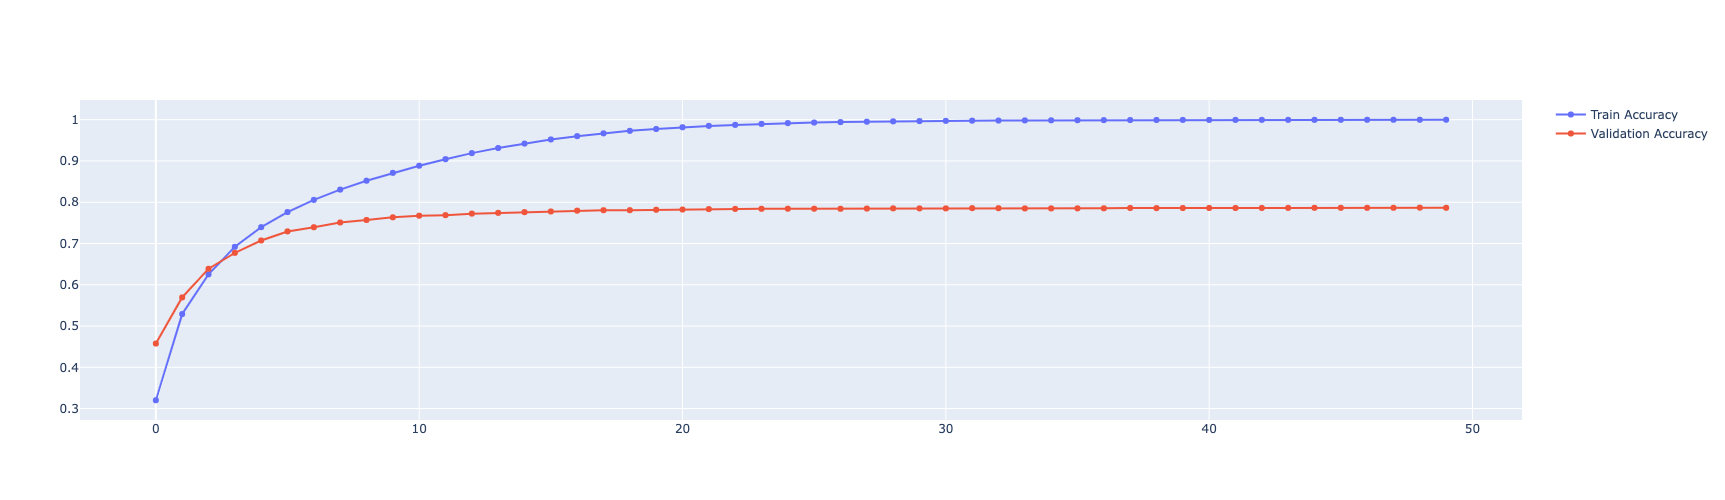

In [76]:
get_model_metrics(y_val, model.predict(X_val_bigram), full_report = 0, plot = 1)